# Phi->ee particle generator

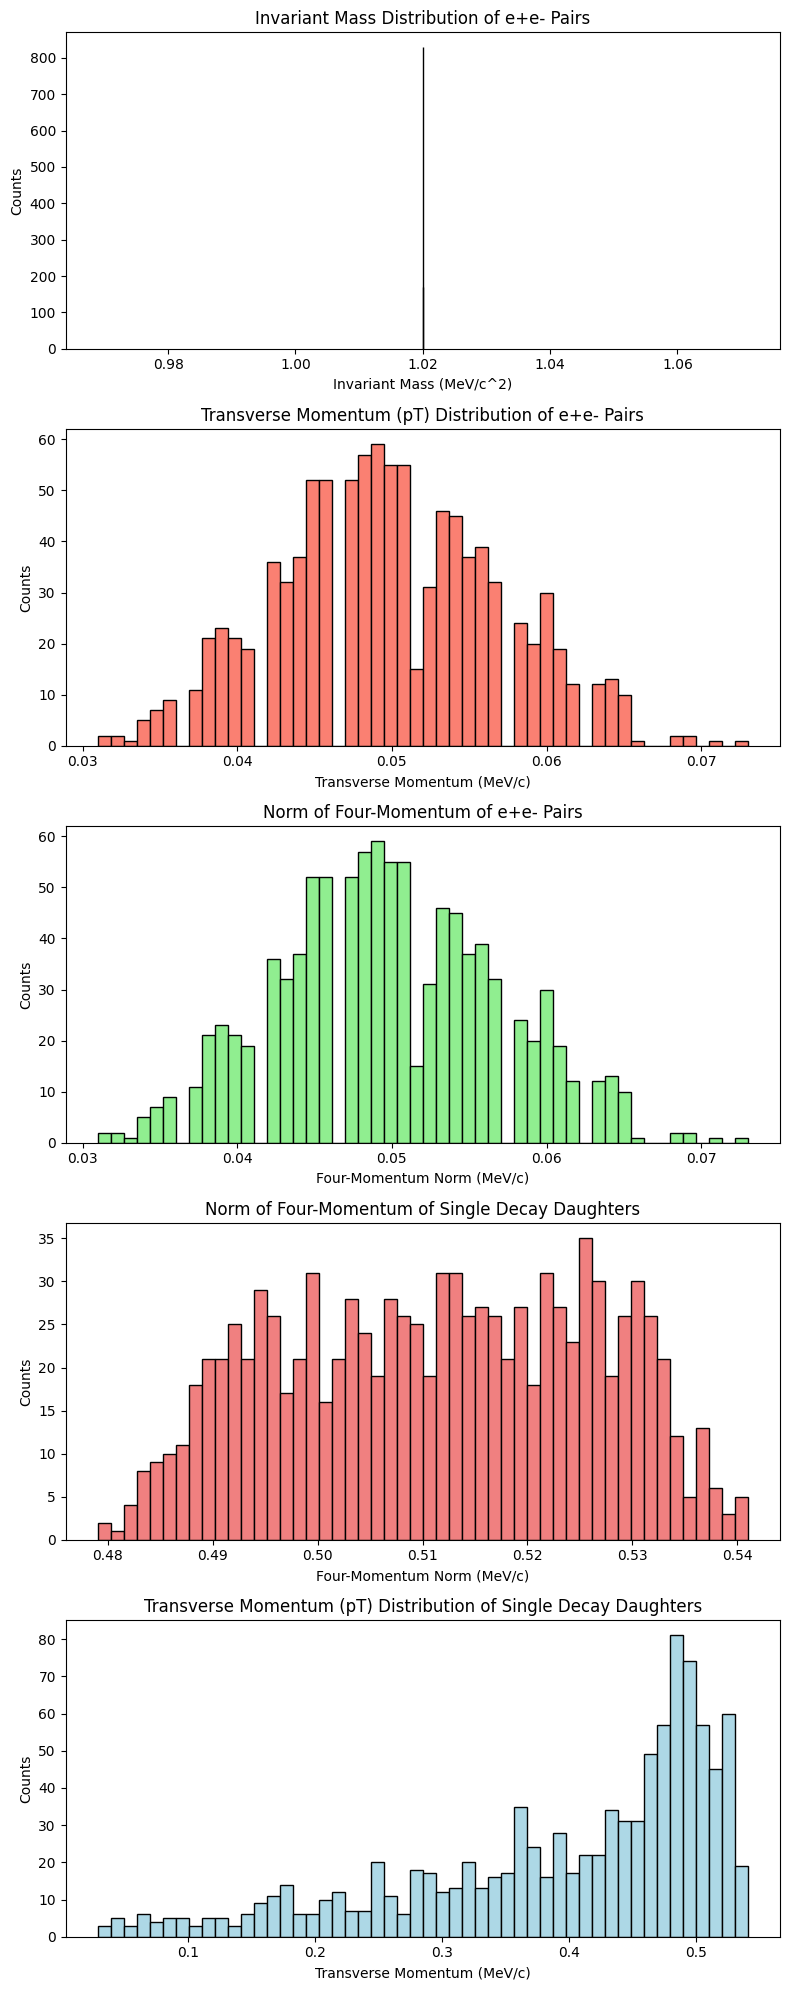

   Event Number  Track Number    Energy        px        py        pz
0             0             1  0.503065 -0.152723  0.059669 -0.475594
1             0             2  0.518885  0.198723 -0.059669  0.475594
2             1             1  0.512954  0.050371 -0.108462  0.498819
3             1             2  0.510566  0.009629  0.108462 -0.498819
4             2             1  0.531377  0.483954  0.109204  0.190327
                                              mother  Event Number    Energy  \
0  MomentumObject4D(px=0.045999976909709694, py=0...             0  1.021950   
1  MomentumObject4D(px=0.05999996988223004, py=0....             1  1.023521   
2  MomentumObject4D(px=0.04599997690970975, py=0....             2  1.021228   
3  MomentumObject4D(px=0.05599997189008138, py=0....             3  1.021733   
4  MomentumObject4D(px=0.05099997439989551, py=0....             4  1.022202   

      px   py   pz  
0  0.046  0.0  0.0  
1  0.060  0.0  0.0  
2  0.046  0.0  0.0  
3  0.056  0.0  

In [3]:
# Re-importing necessary libraries for the updated environment
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import vector

# Constants for phi(1020) and electron mass in GeV/c^2
M_PHI_GEV = 1.02  # mass of phi meson in GeV
M_ELECTRON_GEV = 0.000511  # mass of electron in GeV

# Function to simulate a single phi -> e+ e- decay in the phi rest frame
def decay_phi_to_ee():
    E_electron = M_PHI_GEV / 2  # each electron and positron has half of phi's energy in GeV
    p_electron = np.sqrt(E_electron**2 - M_ELECTRON_GEV**2)
    theta = np.arccos(2 * np.random.rand() - 1)
    phi = 2 * np.pi * np.random.rand()
    px = p_electron * np.sin(theta) * np.cos(phi)
    py = p_electron * np.sin(theta) * np.sin(phi)
    pz = p_electron * np.cos(theta)
    return np.array([px, py, pz]), np.array([-px, -py, -pz])

# Function to boost from phi rest frame to lab frame
def boost_to_lab_frame(p, pT_phi):
    E_phi = np.sqrt(M_PHI_GEV**2 + pT_phi**2)
    gamma_phi = E_phi / M_PHI_GEV
    beta_phi = pT_phi / E_phi
    px, py, pz = p
    px_lab = gamma_phi * (px + beta_phi * np.sqrt(px**2 + py**2 + pz**2))
    py_lab = gamma_phi * py
    pz_lab = gamma_phi * pz
    return np.array([px_lab, py_lab, pz_lab])

# Updated toy generator function with desired pT distribution in GeV
def generate_phi_events_poisson_pt(n_events, peak_pT=0.05):
    electron_momenta = []
    positron_momenta = []
    
    for _ in range(n_events):
        # Sample transverse momentum for phi in GeV (Poisson-like, peak around 0.05 GeV)
        pT_phi = np.random.poisson(peak_pT * 1000) / 1000.0  # Convert peak_pT to MeV for sampling, then back to GeV
        
        # Generate e+ and e- in phi rest frame
        p_e, p_pos = decay_phi_to_ee()
        
        # Boost to lab frame
        p_e_lab = boost_to_lab_frame(p_e, pT_phi)
        p_pos_lab = boost_to_lab_frame(p_pos, pT_phi)
        
        # Store results
        electron_momenta.append(p_e_lab)
        positron_momenta.append(p_pos_lab)
    
    return np.array(electron_momenta), np.array(positron_momenta)

# DataFrame creation function
def generate_phi_daughter_mother_df(n_events, peak_pT_phi=0.05):
    electron_mom, positron_mom = generate_phi_events_poisson_pt(n_events, peak_pT_phi)
    # Recalculate distributions with the new pT distribution
    total_momentum = electron_mom + positron_mom
    total_energy = np.sqrt(np.sum(total_momentum**2, axis=1) + M_PHI_GEV**2)
    invariant_mass = np.sqrt(total_energy**2 - np.sum(total_momentum**2, axis=1))
    pt_ee_pairs = np.sqrt(total_momentum[:, 0]**2 + total_momentum[:, 1]**2)
    four_momentum_norm_ee_pairs = np.sqrt(np.sum(total_momentum**2, axis=1))
    four_momentum_norm_single = np.sqrt(np.sum(electron_mom**2, axis=1))
    pt_single = np.sqrt(electron_mom[:, 0]**2 + electron_mom[:, 1]**2)

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(8, 20))

    axs[0].hist(invariant_mass, bins=50, color='skyblue', edgecolor='black')
    axs[0].set_title("Invariant Mass Distribution of e+e- Pairs")
    axs[0].set_xlabel("Invariant Mass (MeV/c^2)")
    axs[0].set_ylabel("Counts")

    axs[1].hist(pt_ee_pairs, bins=50, color='salmon', edgecolor='black')
    axs[1].set_title("Transverse Momentum (pT) Distribution of e+e- Pairs")
    axs[1].set_xlabel("Transverse Momentum (MeV/c)")
    axs[1].set_ylabel("Counts")

    axs[2].hist(four_momentum_norm_ee_pairs, bins=50, color='lightgreen', edgecolor='black')
    axs[2].set_title("Norm of Four-Momentum of e+e- Pairs")
    axs[2].set_xlabel("Four-Momentum Norm (MeV/c)")
    axs[2].set_ylabel("Counts")

    axs[3].hist(four_momentum_norm_single, bins=50, color='lightcoral', edgecolor='black')
    axs[3].set_title("Norm of Four-Momentum of Single Decay Daughters")
    axs[3].set_xlabel("Four-Momentum Norm (MeV/c)")
    axs[3].set_ylabel("Counts")

    axs[4].hist(pt_single, bins=50, color='lightblue', edgecolor='black')
    axs[4].set_title("Transverse Momentum (pT) Distribution of Single Decay Daughters")
    axs[4].set_xlabel("Transverse Momentum (MeV/c)")
    axs[4].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()

    daughters_list = []
    mothers_list = []
    
    for i in range(n_events):
        # Convert momenta to GeV directly as generated
        px_e, py_e, pz_e = electron_mom[i]
        px_pos, py_pos, pz_pos = positron_mom[i]
        
        # Creating Lorentz vectors for each electron and positron
        vec_e = vector.obj(px=px_e, py=py_e, pz=pz_e, E=np.sqrt(px_e**2 + py_e**2 + pz_e**2 + M_ELECTRON_GEV**2))
        vec_pos = vector.obj(px=px_pos, py=py_pos, pz=pz_pos, E=np.sqrt(px_pos**2 + py_pos**2 + pz_pos**2 + M_ELECTRON_GEV**2))
        
        # Storing daughter particle data
        daughters_list.extend([
            {'Event Number': i, 'Track Number': 1, 'Energy': vec_e.E, 'px': vec_e.px, 'py': vec_e.py, 'pz': vec_e.pz},
            {'Event Number': i, 'Track Number': 2, 'Energy': vec_pos.E, 'px': vec_pos.px, 'py': vec_pos.py, 'pz': vec_pos.pz}
        ])
        
        # Summing the electron and positron vectors to get the mother particle vector (phi)
        mother_vec = vec_e + vec_pos
        mothers_list.append({
            'mother': mother_vec,
            'Event Number': i,
            'Energy': mother_vec.E,
            'px': mother_vec.px,
            'py': mother_vec.py,
            'pz': mother_vec.pz
        })
    
    # Creating DataFrames for daughters and mother particles
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df

# Example usage
n_samples = 1000
daughters_df, mothers_df = generate_phi_daughter_mother_df(n_samples)
print(daughters_df.head())
print(mothers_df.head())

In [4]:
# plot_mass_and_pt_distribution(mothers_df)

# STARlight parser

In [5]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df

# Example usage:
# event_df, vertex_df, track_df = parse_starlight_output('starlight_output.txt')

# Display the dataframes
# print(event_df.head())
# print(vertex_df.head())
# print(track_df.head())


In [6]:
import pandas as pd
import numpy as np
from scipy.constants import c
import vector


# Assuming the parse_starlight_output function from the previous code has been defined

def group_tracks_by_event(track_df):
    grouped_tracks = track_df.groupby('Event Number').apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()
    return grouped_tracks


def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec


def get_mass_from_pdgid(pdgid):
    # This function would return the mass based on PDG ID
    # For simplicity, assuming some common particle masses
    pdg_masses = {
        11: 0.000511,  # Electron mass in GeV/c^2
        13: 0.10566,   # Muon mass in GeV/c^2
        211: 0.13957,  # Pion mass in GeV/c^2
        # Add more particles as needed
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown


def perform_operations_on_event(grouped_tracks):
    """
    Creates a DataFrame with all Lorentz vectors for each event using the vector package.

    Parameters:
    grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

    Returns:
    DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    daughters_list = []
    mothers_list = []

    for event_number, event_tracks in grouped_tracks.items():
        mother = create_lorentz_vector(0., 0., 0., 0.)
        for track in event_tracks:
            mass = get_mass_from_pdgid(track['PDGPID'])
            vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            daughters_list.append({
                'Event Number': event_number,
                'Track Number': track['Track Number'],
                'Energy': vec.E,
                'px': vec.px,
                'py': vec.py,
                'pz': vec.pz
            })
            mother += vec
        mothers_list.append({
            'mother': mother,
            'Energy': mother.E,
            'px': mother.px,
            'py': mother.py,
            'pz': mother.pz
        })

    # Create DataFrame
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df


In [7]:
event_df_gg, vertex_df_gg, track_df_gg = parse_starlight_output('slight-gg.out')
grouped_tracks_gg = group_tracks_by_event(track_df_gg)
daughters_gg_df, gg_df = perform_operations_on_event(grouped_tracks_gg)
print(gg_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.002374000000000015, py=0...  2.605134  0.002374   
1  MomentumObject4D(px=-0.03393200000000002, py=-...  1.011372 -0.033932   
2  MomentumObject4D(px=0.03916300000000006, py=-0...  1.638124  0.039163   
3  MomentumObject4D(px=-0.048740000000000006, py=...  2.768532 -0.048740   
4  MomentumObject4D(px=0.00892900000000002, py=-0...  1.453469  0.008929   

         py        pz  
0  0.000150  1.883961  
1 -0.068489 -0.083270  
2 -0.023573 -0.099818  
3 -0.008025 -0.626137  
4 -0.014635 -0.436247  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_and_pt_distribution(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """

    # Calculate the mass and transverse momentum (p_T) for each row
    df['mass'] = df['mother'].apply(lambda v: v.mass)
    df['pt'] = df['mother'].apply(lambda v: v.pt)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your input DataFrame with a 'mother' column containing vector objects
# plot_mass_and_pt_distribution(df)


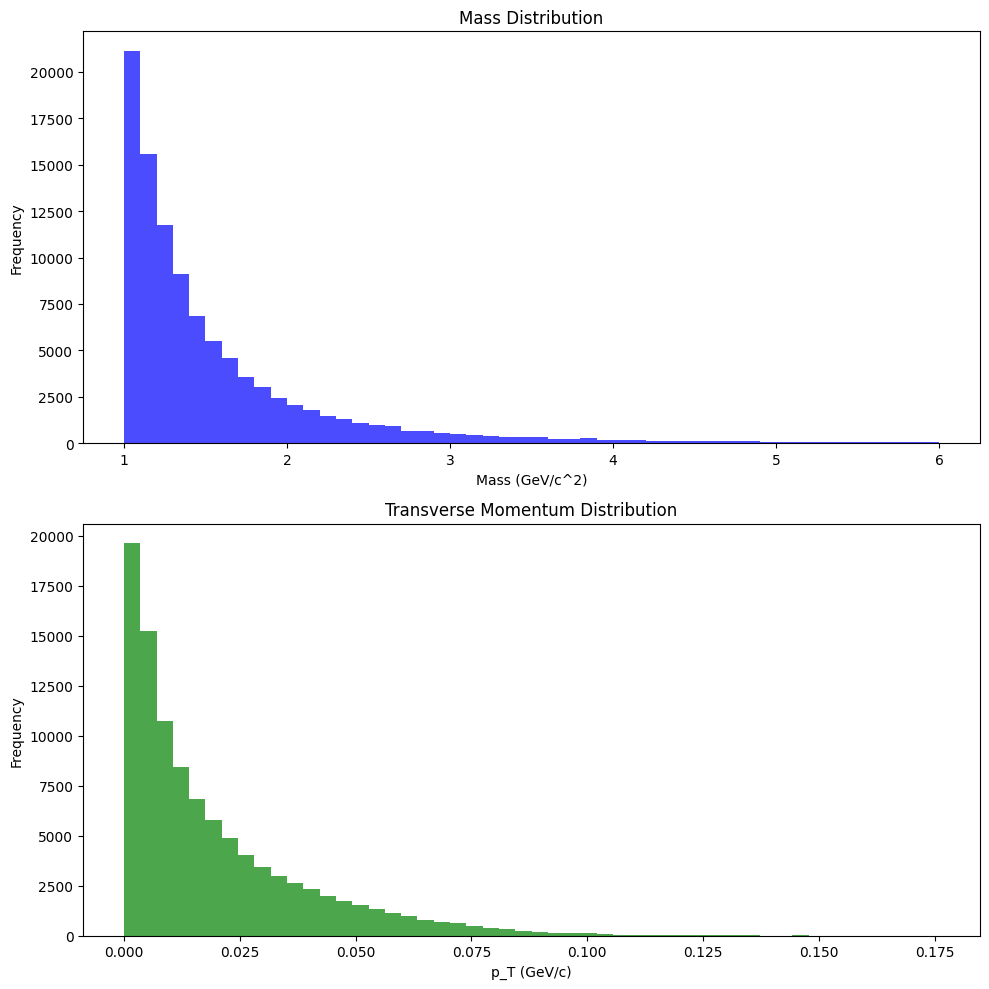

In [9]:
plot_mass_and_pt_distribution(gg_df)

In [10]:
print(daughters_gg_df.head())

   Event Number  Track Number    Energy        px        py        pz
0             1             0  1.266138  0.140385 -0.888044  0.891502
1             1             1  1.338996 -0.138011  0.888194  0.992459
2             2             0  0.521857  0.289636 -0.432667 -0.035278
3             2             1  0.489515 -0.323568  0.364178 -0.047992
4             3             0  0.829362 -0.660527  0.045974 -0.499432


#### Checking distributions

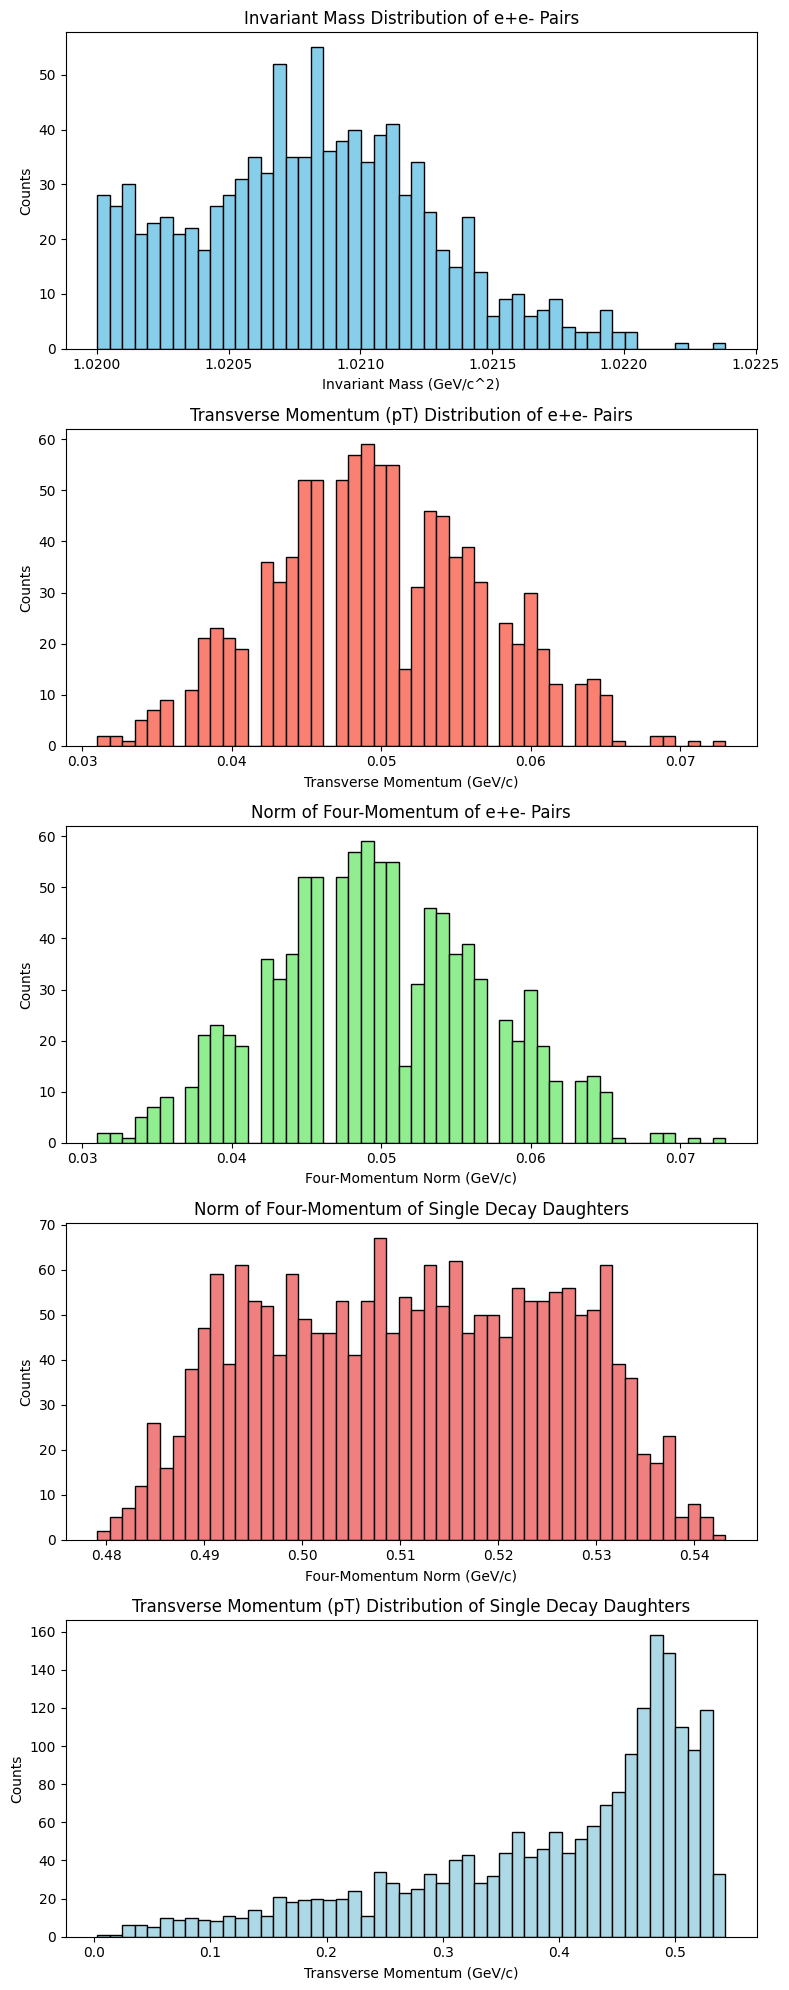

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions_from_daughters(daughters_df):
    """
    Plots invariant mass, transverse momentum, and four-momentum norms of e+e- pairs 
    and single decay daughters based on the input DataFrame.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event number to sum electron and positron four-momenta
    grouped = daughters_df.groupby('Event Number')
    
    # Calculate four-momentum components for e+e- pairs
    px_ee = grouped['px'].sum()
    py_ee = grouped['py'].sum()
    pz_ee = grouped['pz'].sum()
    energy_ee = grouped['Energy'].sum()
    
    # Invariant mass of e+e- pairs
    invariant_mass = np.sqrt(energy_ee**2 - (px_ee**2 + py_ee**2 + pz_ee**2))
    
    # Transverse momentum of e+e- pairs
    pt_ee_pairs = np.sqrt(px_ee**2 + py_ee**2)
    
    # Norm of four-momentum of e+e- pairs
    four_momentum_norm_ee_pairs = np.sqrt(px_ee**2 + py_ee**2 + pz_ee**2)
    
    # For single decay daughters
    four_momentum_norm_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    pt_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2)

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(8, 20))

    axs[0].hist(invariant_mass, bins=50, color='skyblue', edgecolor='black')
    axs[0].set_title("Invariant Mass Distribution of e+e- Pairs")
    axs[0].set_xlabel("Invariant Mass (GeV/c^2)")
    axs[0].set_ylabel("Counts")

    axs[1].hist(pt_ee_pairs, bins=50, color='salmon', edgecolor='black')
    axs[1].set_title("Transverse Momentum (pT) Distribution of e+e- Pairs")
    axs[1].set_xlabel("Transverse Momentum (GeV/c)")
    axs[1].set_ylabel("Counts")

    axs[2].hist(four_momentum_norm_ee_pairs, bins=50, color='lightgreen', edgecolor='black')
    axs[2].set_title("Norm of Four-Momentum of e+e- Pairs")
    axs[2].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[2].set_ylabel("Counts")

    axs[3].hist(four_momentum_norm_single, bins=50, color='lightcoral', edgecolor='black')
    axs[3].set_title("Norm of Four-Momentum of Single Decay Daughters")
    axs[3].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[3].set_ylabel("Counts")

    axs[4].hist(pt_single, bins=50, color='lightblue', edgecolor='black')
    axs[4].set_title("Transverse Momentum (pT) Distribution of Single Decay Daughters")
    axs[4].set_xlabel("Transverse Momentum (GeV/c)")
    axs[4].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_distributions_from_daughters(daughters_df)


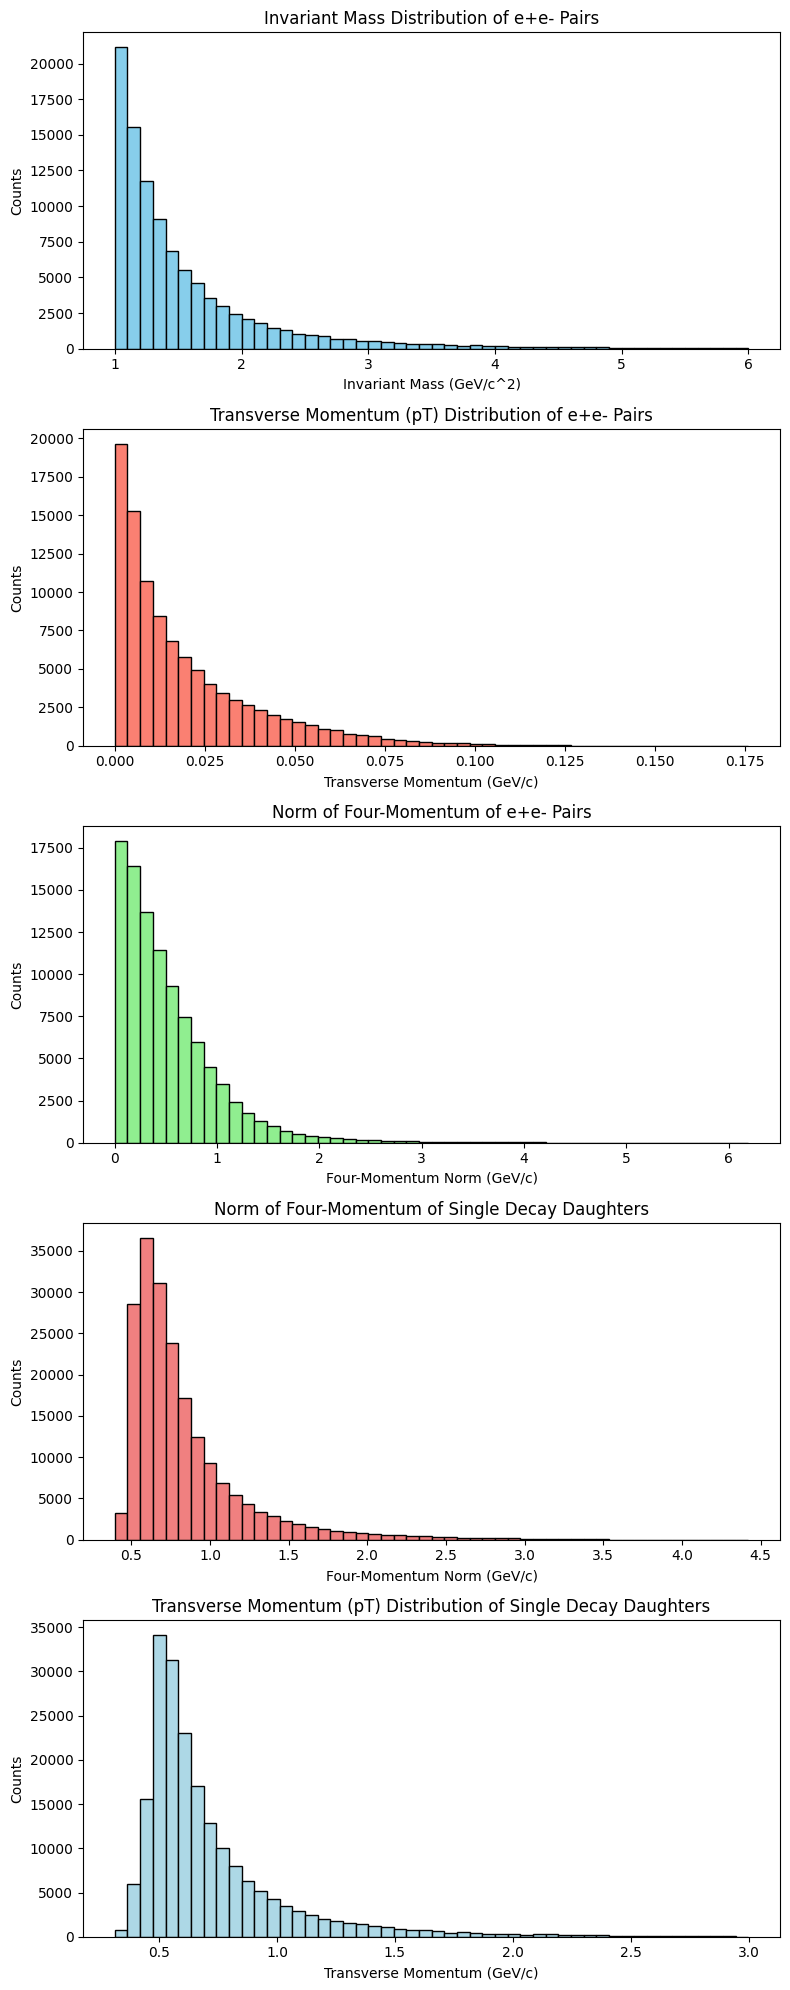

In [12]:
plot_distributions_from_daughters(daughters_gg_df)

### Checking multiple features tht could be fed as input to the ML algorithm

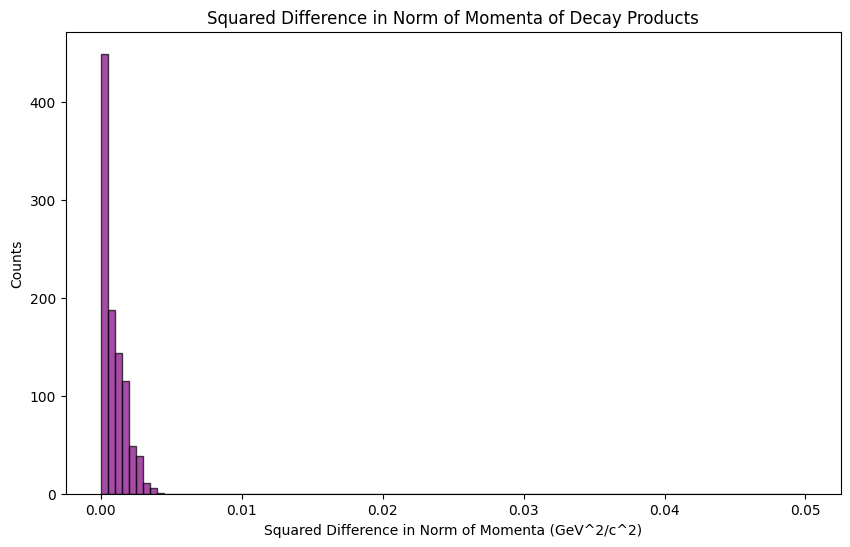

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_squared_momentum_diff(daughters_df):
    """
    Calculates and plots the distribution of the squared difference in norms of the momenta 
    of the two decay products (e+ and e-) in each event.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz'].
    """
    # Calculate the norm of the momenta for each decay product
    daughters_df['momentum_norm'] = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    
    # Group by event and get the norms for e+ and e- in each event
    momentum_norms = daughters_df.groupby('Event Number')['momentum_norm'].apply(list)
    
    # Calculate the squared difference in norms for each event
    squared_diff = [(norms[0] - norms[1])**2 for norms in momentum_norms if len(norms) == 2]
    
    # Plot the distribution with fixed binning
    plt.figure(figsize=(10, 6))
    plt.hist(squared_diff, bins=100, range=(-0.0, 0.05), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Squared Difference in Norm of Momenta of Decay Products")
    plt.xlabel("Squared Difference in Norm of Momenta (GeV^2/c^2)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
plot_squared_momentum_diff(daughters_df)


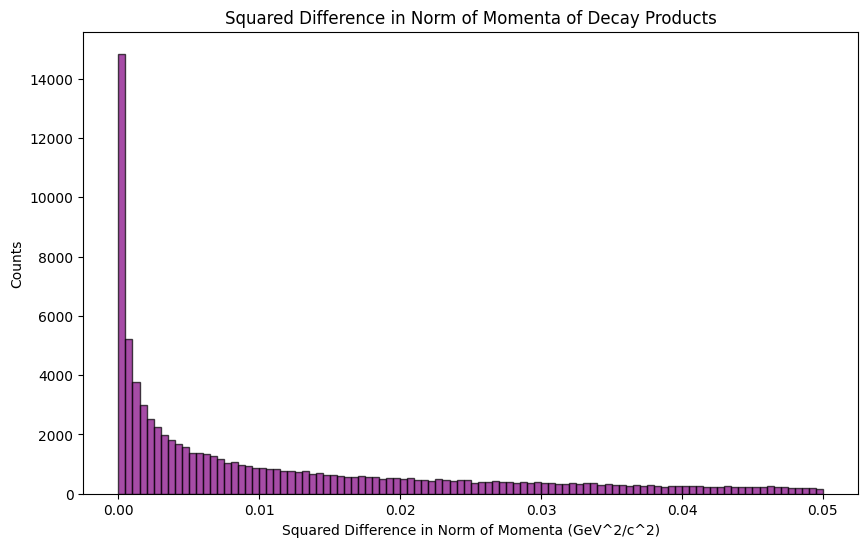

In [14]:
plot_squared_momentum_diff(daughters_gg_df)

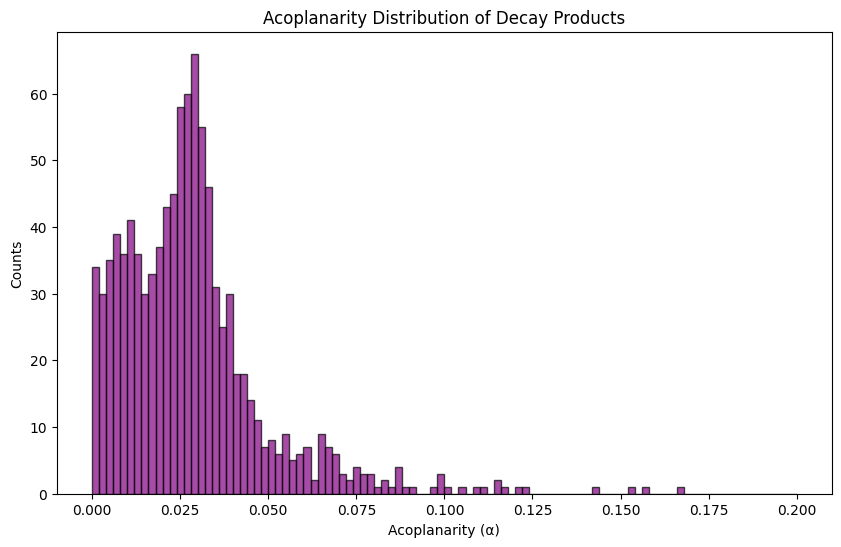

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_acoplanarity(daughters_df):
    """
    Calculates and plots the acoplanarity (alpha) for a dataset of decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py'].
    """
    # Calculate the azimuthal angle (phi) for each particle
    daughters_df['phi'] = np.arctan2(daughters_df['py'], daughters_df['px'])
    
    # Group by event and get the azimuthal angles for each event
    phi_angles = daughters_df.groupby('Event Number')['phi'].apply(list)
    
    # Calculate acoplanarity for each event
    acoplanarity = [1 - abs(phis[0] - phis[1]) / np.pi for phis in phi_angles if len(phis) == 2]
    
    # Plot the acoplanarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(acoplanarity, bins=100, range=(0, 0.2), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Acoplanarity Distribution of Decay Products")
    plt.xlabel("Acoplanarity (α)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_acoplanarity(daughters_df)


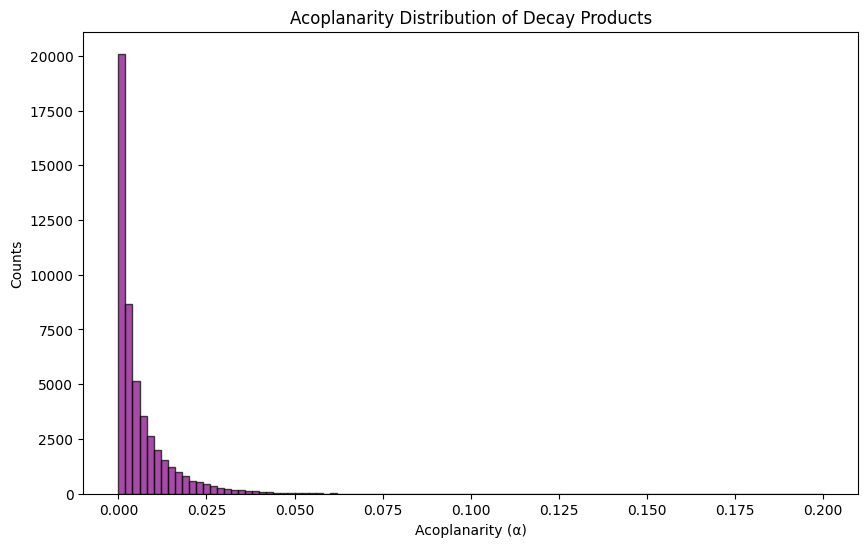

In [16]:
calculate_and_plot_acoplanarity(daughters_gg_df)


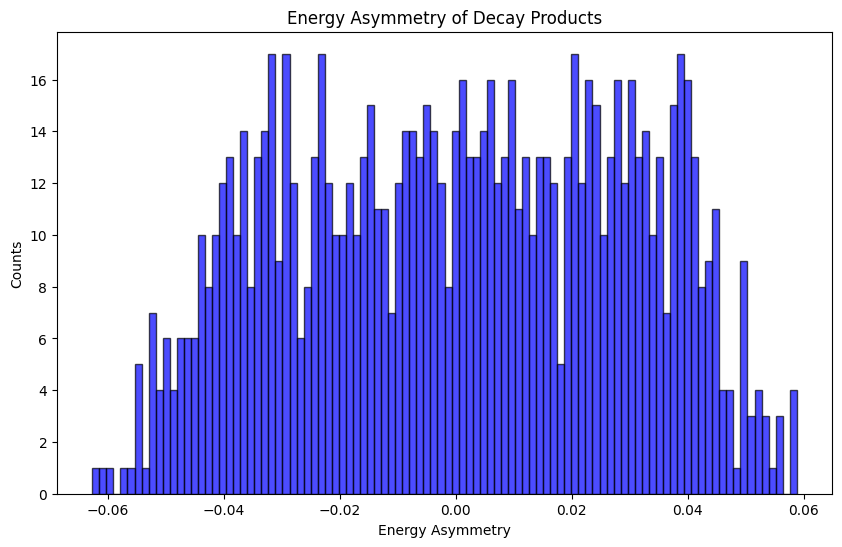

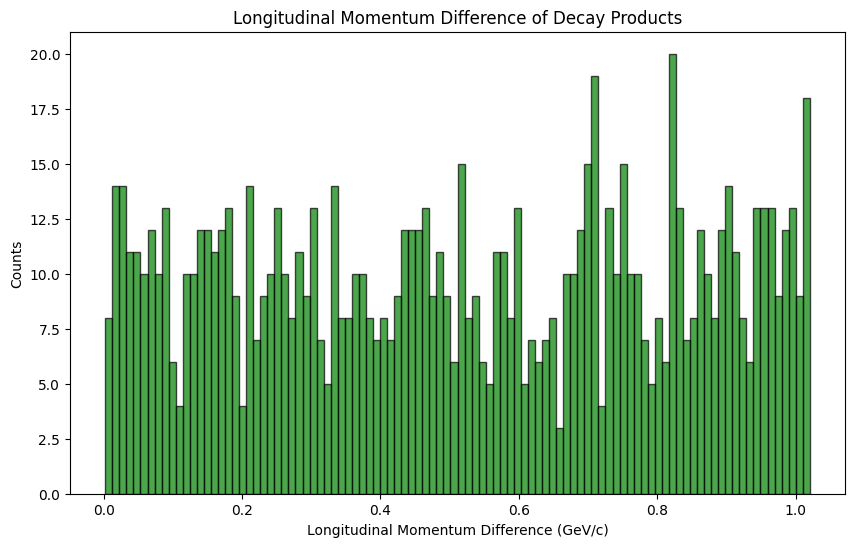

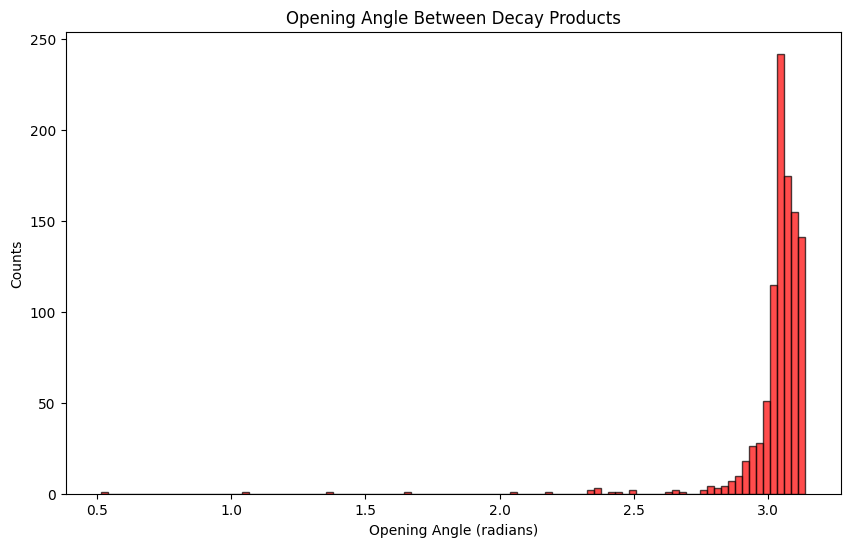

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_additional_features(daughters_df):
    """
    Calculates and plots distributions for energy asymmetry, longitudinal momentum difference, 
    and opening angle between decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event and get the properties for each particle in each event
    grouped = daughters_df.groupby('Event Number')
    energies = grouped['Energy'].apply(list)
    pz_values = grouped['pz'].apply(list)
    px_values = grouped['px'].apply(list)
    py_values = grouped['py'].apply(list)
    
    # Calculate Energy Asymmetry for each event
    energy_asymmetry = [(e[0] - e[1]) / (e[0] + e[1]) for e in energies if len(e) == 2]
    
    # Calculate Longitudinal Momentum Difference for each event
    longitudinal_momentum_diff = [abs(pz[0] - pz[1]) for pz in pz_values if len(pz) == 2]
    
    # Calculate Opening Angle for each event
    opening_angles = []
    for px, py in zip(px_values, py_values):
        if len(px) == 2 and len(py) == 2:
            p1 = np.array([px[0], py[0]])
            p2 = np.array([px[1], py[1]])
            cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
            opening_angles.append(np.arccos(cos_theta))

    # Plot Energy Asymmetry
    plt.figure(figsize=(10, 6))
    plt.hist(energy_asymmetry, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.title("Energy Asymmetry of Decay Products")
    plt.xlabel("Energy Asymmetry")
    plt.ylabel("Counts")
    plt.show()
    
    # Plot Longitudinal Momentum Difference
    plt.figure(figsize=(10, 6))
    plt.hist(longitudinal_momentum_diff, bins=100, color='green', edgecolor='black', alpha=0.7)
    plt.title("Longitudinal Momentum Difference of Decay Products")
    plt.xlabel("Longitudinal Momentum Difference (GeV/c)")
    plt.ylabel("Counts")
    plt.show()

    # Plot Opening Angle
    plt.figure(figsize=(10, 6))
    plt.hist(opening_angles, bins=100, color='red', edgecolor='black', alpha=0.7)
    plt.title("Opening Angle Between Decay Products")
    plt.xlabel("Opening Angle (radians)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_additional_features(daughters_df)


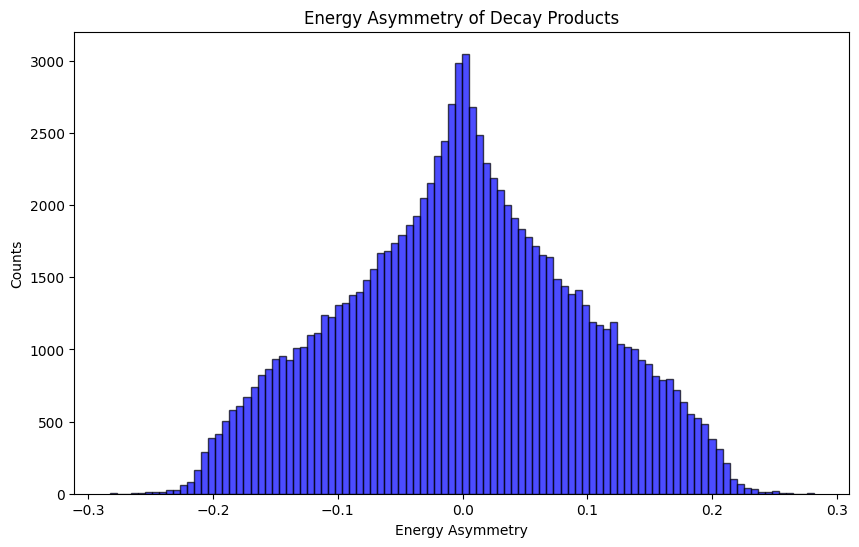

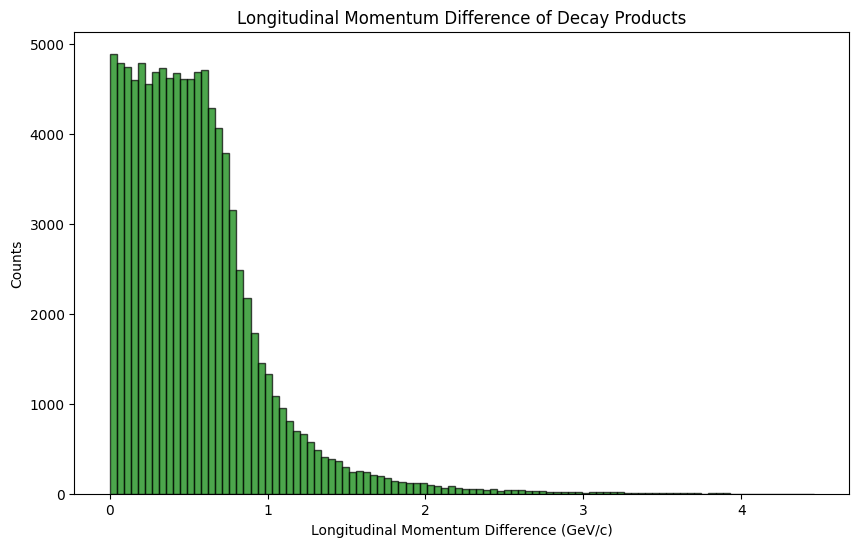

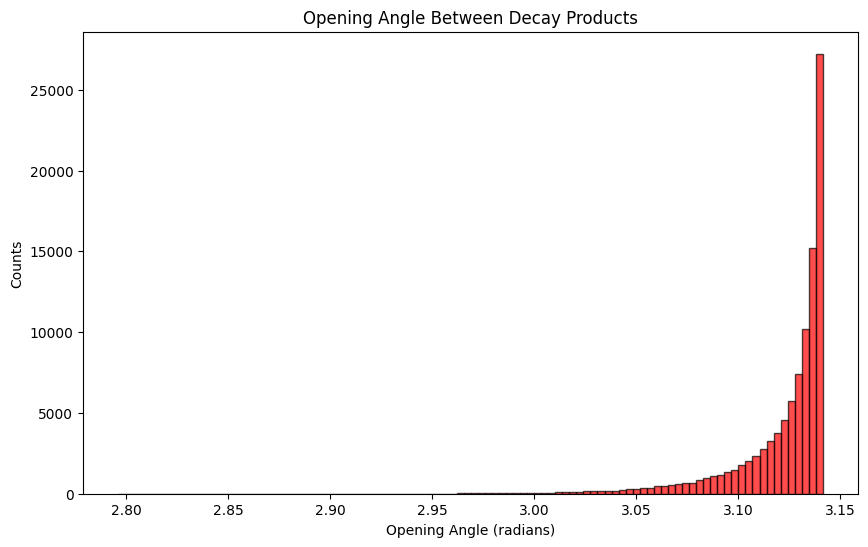

In [18]:
calculate_and_plot_additional_features(daughters_gg_df)


## Feature engineering

In [19]:
import numpy as np

def filter_by_acceptance(daughters_df):
    """
    Filters events based on acceptance criteria:
    - Each track must have pseudorapidity |eta| < 0.8
    - The mother particle (sum of two decay products) must have rapidity |y| < 0.8
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: Filtered DataFrame with events that meet the acceptance criteria.
    """
    # Calculate pseudorapidity (eta) for each track
    daughters_df['eta'] = 0.5 * np.log((np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) + daughters_df['pz']) /
                                       (np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) - daughters_df['pz']))
    
    # Filter tracks based on |eta| < 0.8
    eta_filtered = daughters_df[np.abs(daughters_df['eta']) < 0.8]
    
    # Group by event and calculate the total four-momentum of the mother particle
    grouped = eta_filtered.groupby('Event Number')
    mother_px = grouped['px'].sum()
    mother_py = grouped['py'].sum()
    mother_pz = grouped['pz'].sum()
    mother_energy = grouped['Energy'].sum()
    
    # Calculate rapidity (y) of the mother particle
    mother_rapidity = 0.5 * np.log((mother_energy + mother_pz) / (mother_energy - mother_pz))
    
    # Filter events based on |y| < 0.8 for the mother particle
    accepted_events = mother_rapidity[np.abs(mother_rapidity) < 0.8].index
    filtered_daughters_df = eta_filtered[eta_filtered['Event Number'].isin(accepted_events)]
    
    return filtered_daughters_df

# Example usage:
filtered_daughters_df = filter_by_acceptance(daughters_df)
filtered_daughters_gg_df = filter_by_acceptance(daughters_gg_df)


In [20]:
def compute_features(daughters_df):
    """
    Computes a set of features from the input filtered DataFrame, including:
    - Invariant mass of the e+e- pair
    - Transverse momentum (pT) of the e+e- pair
    - Squared difference in norms of momenta
    - Acoplanarity
    - Energy asymmetry
    - Longitudinal momentum difference
    - Opening angle between decay products
    
    Parameters:
    daughters_df (pd.DataFrame): Filtered DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: DataFrame containing computed features for each event.
    """
    # Group by event to compute pair-level features
    grouped = daughters_df.groupby('Event Number')
    
    # Initialize lists to collect computed features
    event_numbers = []
    invariant_masses = []
    pt_ee_pairs = []
    squared_momentum_diffs = []
    acoplanarities = []
    energy_asymmetries = []
    longitudinal_momentum_diffs = []
    opening_angles = []
    
    # Loop over each event
    for event_num, group in grouped:
        if len(group) != 2:
            continue  # Only process events with exactly two tracks

        # Extract track-level variables
        px1, py1, pz1, E1 = group.iloc[0][['px', 'py', 'pz', 'Energy']]
        px2, py2, pz2, E2 = group.iloc[1][['px', 'py', 'pz', 'Energy']]
        
        # Event-level variables
        event_numbers.append(event_num)
        
        # 1. Invariant mass of the e+e- pair
        total_energy = E1 + E2
        total_px = px1 + px2
        total_py = py1 + py2
        total_pz = pz1 + pz2
        invariant_mass = np.sqrt(total_energy**2 - total_px**2 - total_py**2 - total_pz**2)
        invariant_masses.append(invariant_mass)
        
        # 2. Transverse momentum (pT) of the e+e- pair
        pt_ee_pairs.append(np.sqrt(total_px**2 + total_py**2))
        
        # 3. Squared difference in norms of momenta
        norm1 = np.sqrt(px1**2 + py1**2 + pz1**2)
        norm2 = np.sqrt(px2**2 + py2**2 + pz2**2)
        squared_momentum_diffs.append((norm1 - norm2)**2)
        
        # 4. Acoplanarity
        phi1 = np.arctan2(py1, px1)
        phi2 = np.arctan2(py2, px2)
        phi_diff = abs(phi1 - phi2)
        phi_diff = min(phi_diff, 2 * np.pi - phi_diff)  # Ensure difference is within [0, π]
        acoplanarity = 1 - phi_diff / np.pi
        acoplanarities.append(acoplanarity)
        
        # 5. Energy asymmetry
        energy_asymmetry = (E1 - E2) / (E1 + E2)
        energy_asymmetries.append(energy_asymmetry)
        
        # 6. Longitudinal momentum difference
        longitudinal_momentum_diffs.append(abs(pz1 - pz2))
        
        # 7. Opening angle between decay products
        p1 = np.array([px1, py1, pz1])
        p2 = np.array([px2, py2, pz2])
        cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
        opening_angle = np.arccos(cos_theta)
        opening_angles.append(opening_angle)

    # Construct DataFrame with all computed features
    features_df = pd.DataFrame({
        'Event Number': event_numbers,
        'Invariant Mass': invariant_masses,
        'pT (e+e-)': pt_ee_pairs,
        'Squared Momentum Difference': squared_momentum_diffs,
        'Acoplanarity': acoplanarities,
        'Energy Asymmetry': energy_asymmetries,
        'Longitudinal Momentum Difference': longitudinal_momentum_diffs,
        'Opening Angle': opening_angles
    })
    
    return features_df

# filtered_daughters_df = filter_by_acceptance(daughters_df)
features_df = compute_features(filtered_daughters_df)
features_gg_df = compute_features(filtered_daughters_gg_df)


In [21]:
features_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,2,1.020192,0.046,0.001724,0.007141,0.040663,0.380654,3.102805
1,3,1.020197,0.056,0.002734,0.012321,-0.051178,0.072198,3.102304
2,4,1.020929,0.051,0.000704,0.028655,0.025958,0.422894,3.056323
3,5,1.020598,0.051,0.001381,0.021236,0.036370,0.377811,3.073179
4,6,1.020224,0.039,0.001064,0.013266,-0.031946,0.092604,3.099681


In [22]:
features_gg_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,2,1.005036,0.076434,0.001046,0.043453,0.031978,0.012714,2.926895
1,3,1.634441,0.045710,0.000424,0.009416,0.012576,0.899046,3.009829
2,4,2.696346,0.049396,0.000018,0.008649,0.001532,0.123991,2.683888
3,5,1.386350,0.017144,0.020675,0.001141,0.098929,0.427441,2.563553
4,7,1.108427,0.016459,0.000012,0.008464,-0.003088,0.092793,3.051142


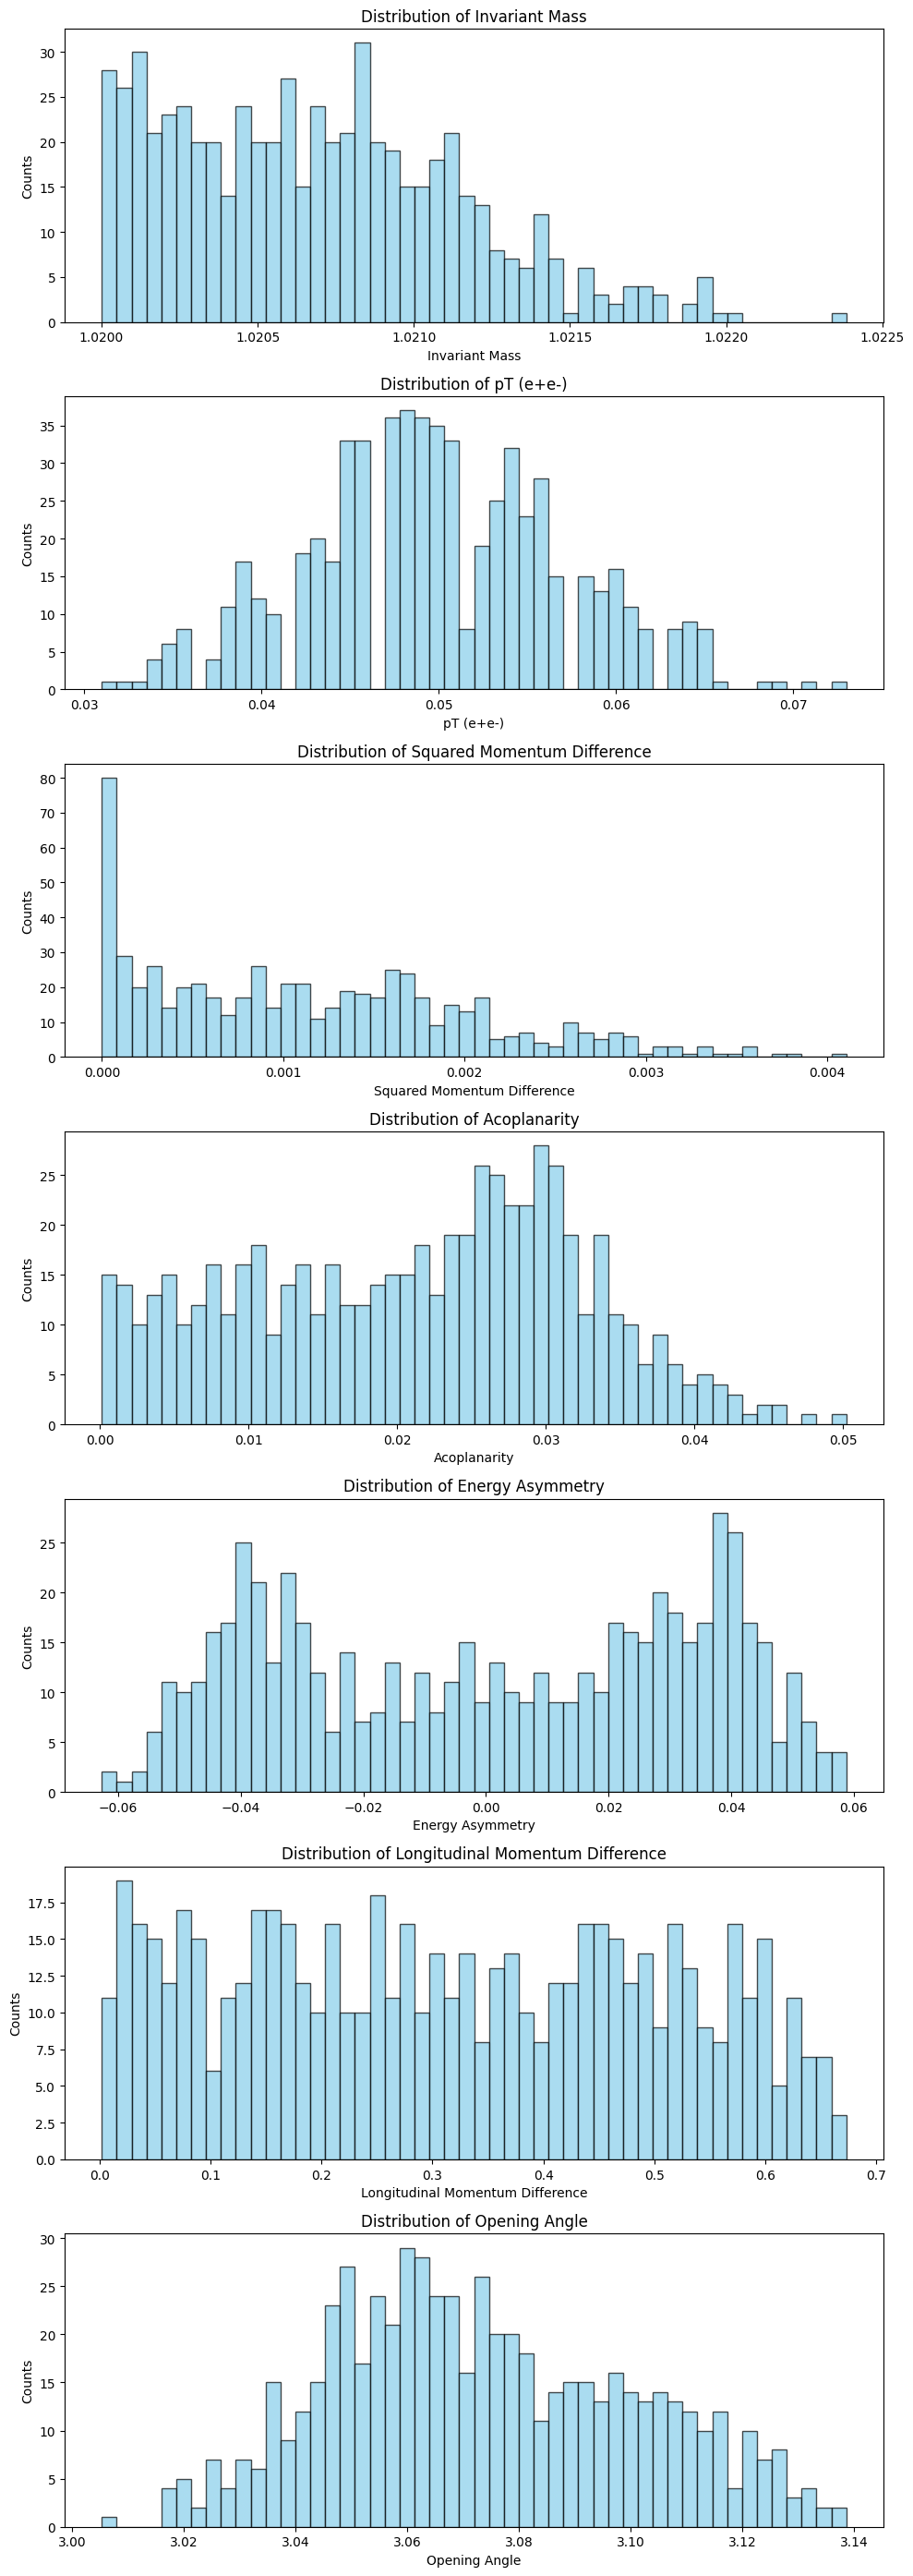

In [23]:
import matplotlib.pyplot as plt

def plot_features(features_df):
    """
    Plots histograms for each feature in the features DataFrame.
    
    Parameters:
    features_df (pd.DataFrame): DataFrame containing computed features for each event.
    """
    # Set up a figure with subplots for each feature
    n_features = features_df.shape[1] - 1  # Exclude the 'Event Number' column
    fig, axs = plt.subplots(n_features, 1, figsize=(10, 4 * n_features))
    
    # Plot each feature in a separate subplot
    for i, col in enumerate(features_df.columns[1:]):  # Skip 'Event Number' column
        axs[i].hist(features_df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axs[i].set_title(f"Distribution of {col}")
        axs[i].set_xlabel(col)
        axs[i].set_ylabel("Counts")
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_features(features_df)


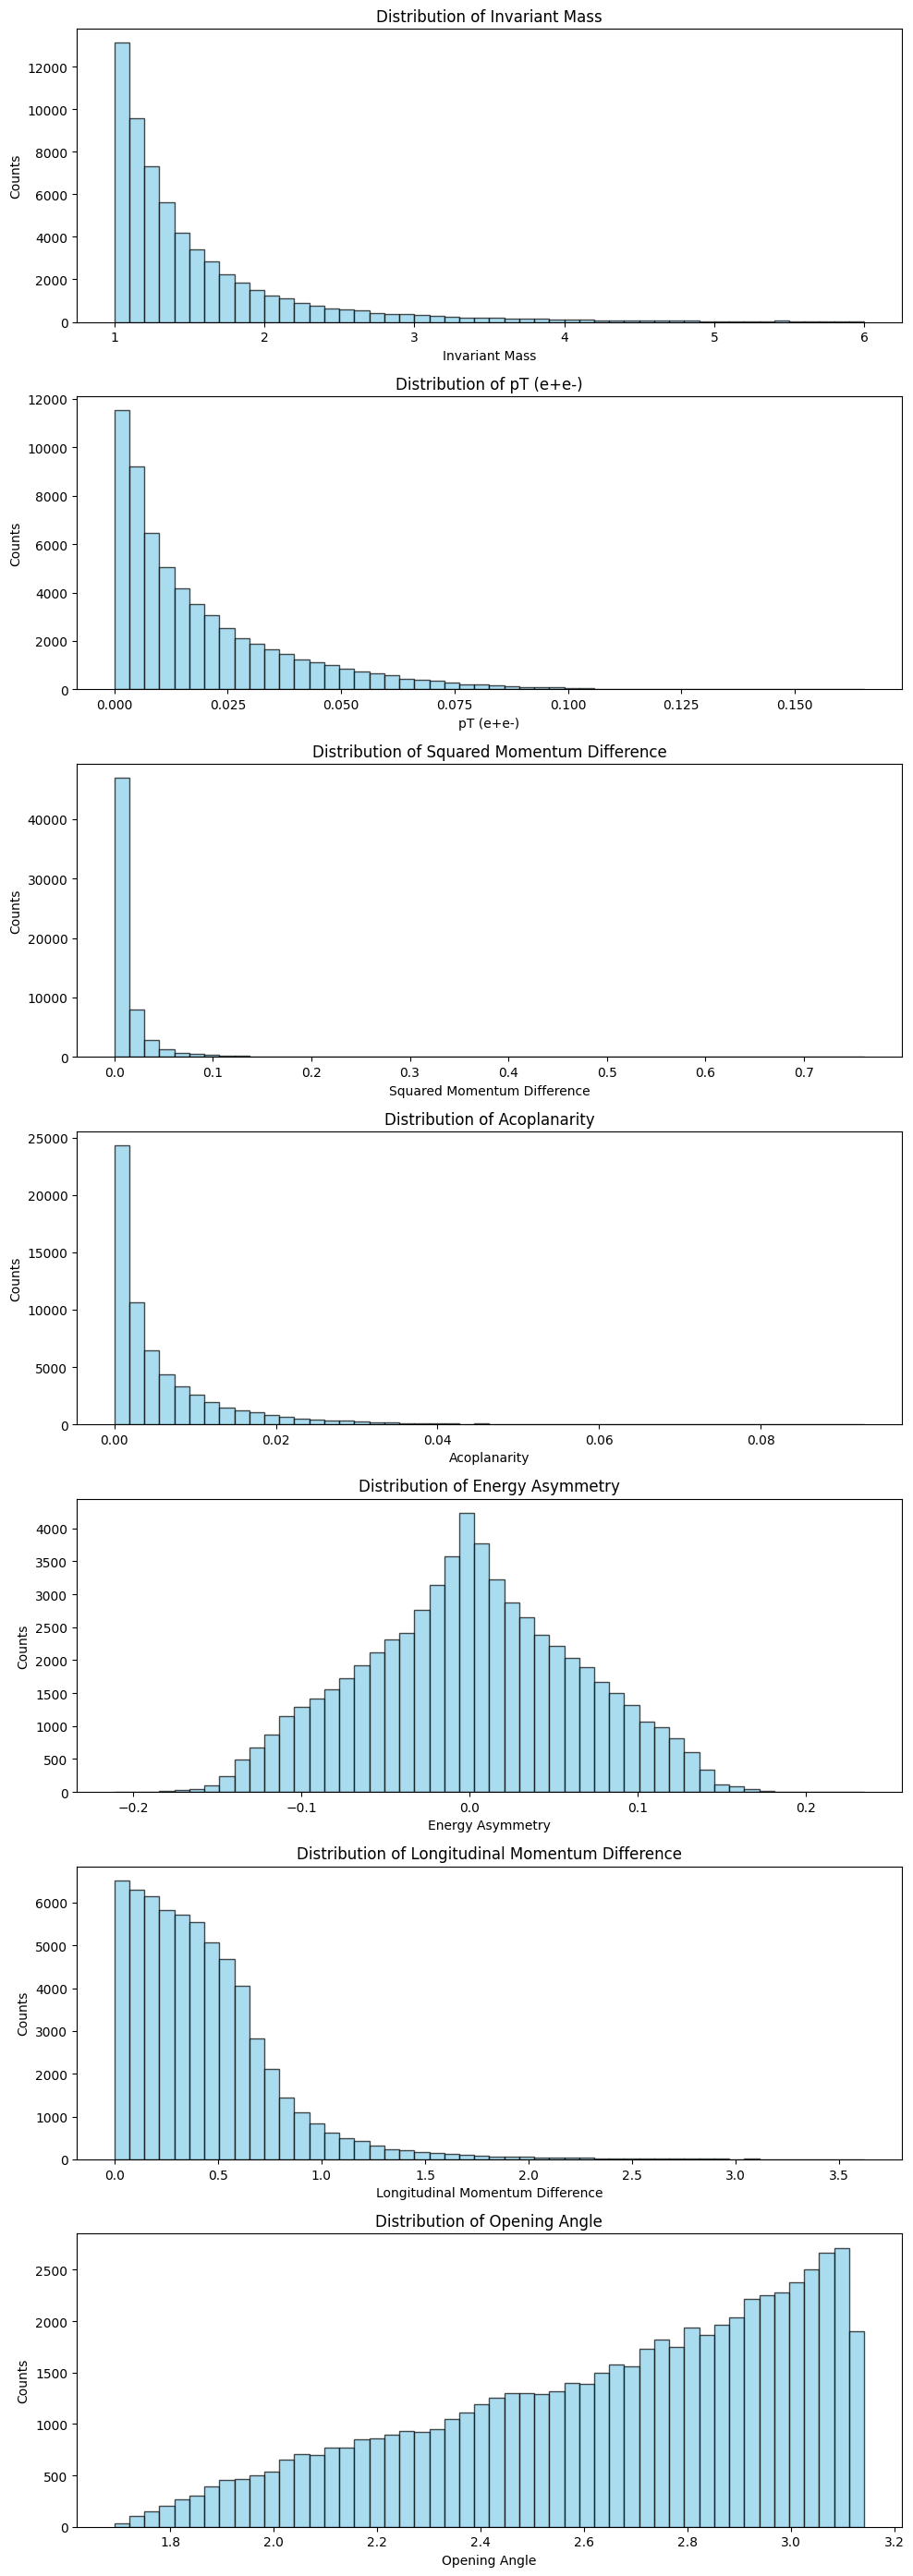

In [24]:
plot_features(features_gg_df)


### Random forest

Accuracy: 1.000
ROC-AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18505
           1       1.00      0.97      0.99       182

    accuracy                           1.00     18687
   macro avg       1.00      0.99      0.99     18687
weighted avg       1.00      1.00      1.00     18687



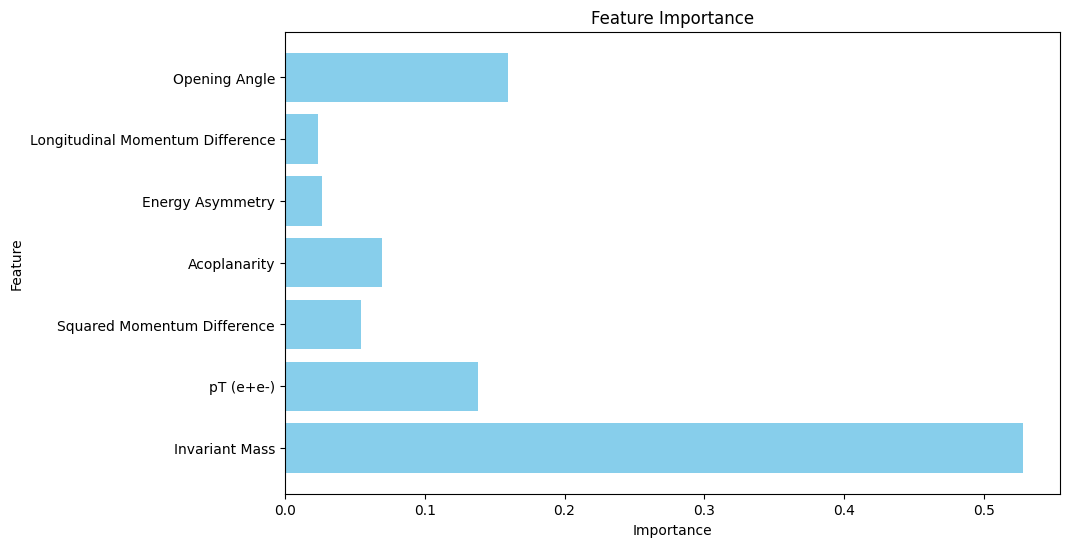

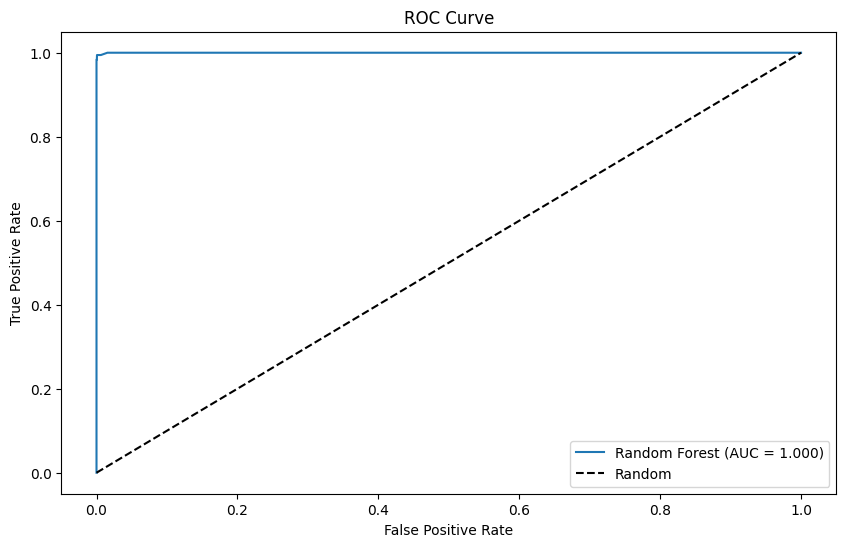

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def prepare_data(phi_features_df, photon_features_df):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    combined_df = pd.concat([phi_features_df, photon_features_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y

def train_random_forest(X, y):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Labels
    
    Returns:
    model: Trained Random Forest model
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    return rf_model

# Example usage:
X, y = prepare_data(features_df, features_gg_df)
rf_model = train_random_forest(X, y)


### Now selecting only the right invariant mass region

Accuracy: 0.986
ROC-AUC: 0.997

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1718
           1       0.92      0.95      0.94       205

    accuracy                           0.99      1923
   macro avg       0.96      0.97      0.96      1923
weighted avg       0.99      0.99      0.99      1923



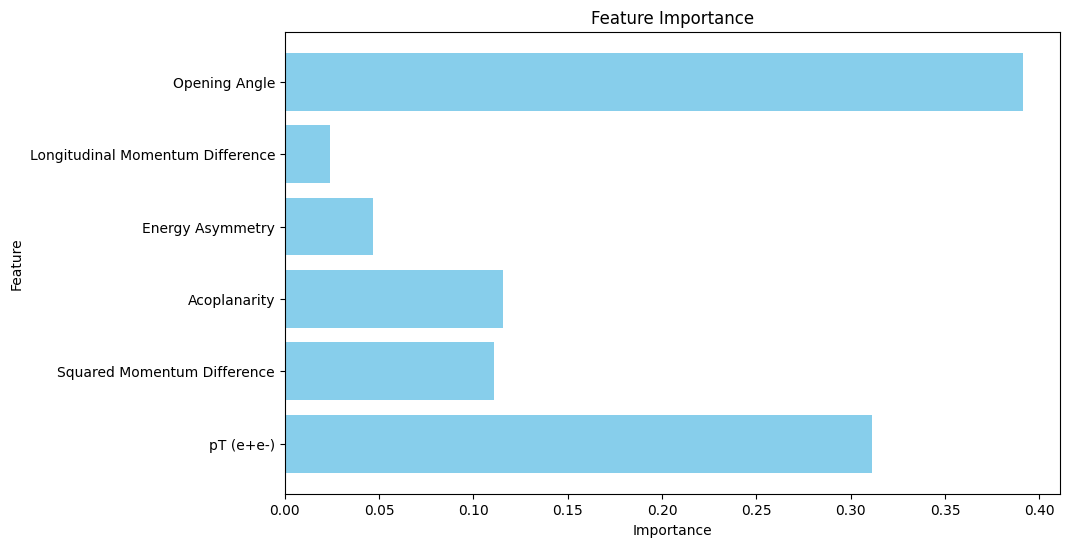

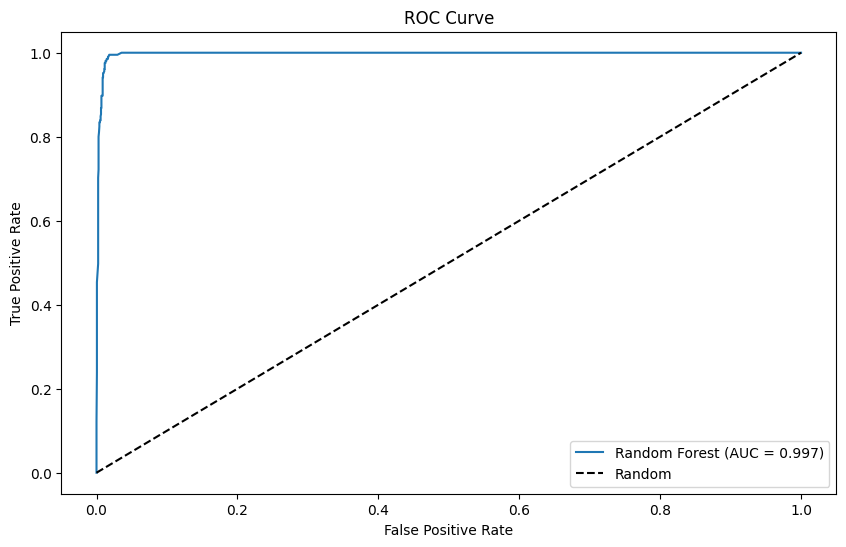

In [26]:
def prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    filtered_df = photon_features_df[(photon_features_df['Invariant Mass'] >= mass_min) & (photon_features_df['Invariant Mass'] <= mass_max)]
    combined_df = pd.concat([phi_features_df, filtered_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Invariant Mass', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y


# def filter_mass_range(features_df, mass_min=1.0, mass_max=1.04):
#     """
#     Filters events within a specified invariant mass range.
    
#     Parameters:
#     features_df (pd.DataFrame): DataFrame containing features, including 'Invariant Mass'.
#     mass_min (float): Minimum invariant mass for filtering.
#     mass_max (float): Maximum invariant mass for filtering.
    
#     Returns:
#     pd.DataFrame: Filtered DataFrame within the specified mass range.
#     """
#     return features_df[(features_df['Invariant Mass'] >= mass_min) & (features_df['Invariant Mass'] <= mass_max)]

# Filter the dataset for the desired mass range
# filtered_features_gg_df = filter_mass_range(features_gg_df, mass_min=1.0, mass_max=1.04)

X_filtered, y_filtered = prepare_filter_mass_range_data(features_df, features_gg_df)
rf_model_filtered = train_random_forest(X_filtered, y_filtered)

# Prepare data, excluding 'Invariant Mass' column
# X_filtered = filtered_features_gg_df.drop(columns=['Invariant Mass'])
# # X_filtered = filtered_features_df.drop(columns=['Event Number', 'Label', 'Invariant Mass'])
# y_filtered = filtered_features_gg_df['Label']
# X_filtered
# Train a new Random Forest model on this filtered dataset
# rf_model_filtered = train_random_forest(X_filtered, y_filtered)
